In [1]:
# All imports/seeds
import torch
import os
from torch import nn
from model.mlp import MLP
from dataloader.utils import get_val_test_ids
from personal_utils import  (get_models_and_files, get_dataloaders_and_datasets,
                             get_embedding_files, send_through_model, send_through_patch_model,
                             send_through_decoder, generate_saliency_map, plot_saliency_map, plot_saliency_map_old, alter_q_data, plot_reconstruction_difference)
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random
import torch.nn.functional as F

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

from pandas import *
# xls = ExcelFile('Losses meiner Modelle.xlsx')
# impact_ranges_dict = xls.parse(xls.sheet_names[4]).to_dict()
from model.vq_vae import VectorQuantizedVAE
from model.vq_vae_patch_embedd import VQVAEPatch

_, _, _, train_data, val_data, test_data, train_labels, val_labels, test_labels = get_dataloaders_and_datasets()
vqvae_v1_files = dict(model='VQ-VAE-asimow-best.ckpt', mlp='my_trained_mlp.ckpt', q_emb='q_emb_v1.npy', q_ind='q_ind_v1.npy', type='VQ-VAE')
vqvae_v1_files_alternate_mlp = dict(model='VQ-VAE-asimow-best.ckpt', mlp='my_trained_mlp_11_03.ckpt', q_emb='q_emb_v1.npy', q_ind='q_ind_v1.npy', type='VQ-VAE')
vvqvae_v1_files_alternate_mlp_2 = dict(model='VQ-VAE-asimow-best.ckpt', mlp='my_trained_mlp_28_03_v2.ckpt', q_emb='q_emb_v1.npy', q_ind='q_ind_v1.npy', type='VQ-VAE')

patch_vqvae_v1_files = dict(model='VQ-VAE-Patch-best-v1.ckpt', mlp='my_trained_mlp_on_patch_v1.ckpt', q_emb='patch_q_emb_v1.npy', q_ind='patch_q_ind_v1.npy', type='VQ-VAE-Patch')
patch_vqvae_v2_files = dict(model='VQ-VAE-Patch-best-v2.ckpt', mlp='my_trained_mlp_on_patch_v2.ckpt', q_emb='patch_q_emb_v2.npy', q_ind='patch_q_ind_v2.npy', type='VQ-VAE-Patch')
patch_vqvae_v4_files = dict(model='VQ-VAE-Patch-best-v4.ckpt', mlp='my_trained_mlp_on_patch_v4.ckpt', q_emb='patch_q_emb_v4.npy', q_ind='patch_q_ind_v4.npy', type='VQ-VAE-Patch')
patch_vqvae_v5_files = dict(model='VQ-VAE-Patch-best-v5.ckpt', mlp='my_trained_mlp_on_patch_v5.ckpt', q_emb='patch_q_emb_v5.npy', q_ind='patch_q_ind_v5.npy', type='VQ-VAE-Patch')
y_patch_vqvae_files = dict(model='Y-VQ-VAE-Patch-best.ckpt', mlp='my_trained_mlp_on_y_patch.ckpt', q_emb='y_patch_q_emb.npy', q_ind='y_patch_q_ind.npy', type='VQ-VAE-Patch')

def get_files_and_models(files: dict):
    # extract file paths from files dict
    model_path = f"./model_checkpoints/{files['type']}/{files['model']}"
    mlp_path = f"./MLPs/{files['mlp']}"
    q_emb_path = f"./created_files/{files['q_emb']}"
    q_ind_path = f"./created_files/{files['q_ind']}"

    # load model
    model_dict = torch.load(model_path, map_location=torch.device('cpu'))
    vqvae_hparams = model_dict['hyper_parameters']
    if files['type']=='VQ-VAE':
        # hparams.pop('logger')
        model = VectorQuantizedVAE(**vqvae_hparams)
        model.load_state_dict(model_dict['state_dict'])

    elif files['type']=='VQ-VAE-Patch':
        if 'use_improved_vq' not in vqvae_hparams: vqvae_hparams['use_improved_vq'] = None
        model = VQVAEPatch(**vqvae_hparams)
        model.load_state_dict(model_dict['state_dict'])
    model.eval()

    # load mlp
    n_hidden_layers = 4
    if files['mlp']=='my_trained_mlp_28_03_v2.ckpt': n_hidden_layers = 16
    my_mlp = MLP(input_size=model.enc_out_len, output_size=2, in_dim=model.embedding_dim, hidden_sizes=512, n_hidden_layers=n_hidden_layers)
    my_mlp.load_state_dict(torch.load(mlp_path))
    my_mlp.eval()
    mlp_hparams = my_mlp.hparams

    # extract codebook and load quantized embeddings
    if files['type']=='VQ-VAE-Patch' and vqvae_hparams["use_improved_vq"]:
        codebook = torch.round(model.vector_quantization.vq.codebooks[0], decimals=3)
    else:
        codebook = torch.round(model.vector_quantization.embedding.weight.data, decimals=3)
    q_emb = torch.round(torch.tensor(np.load(q_emb_path), dtype=torch.float32), decimals=3)
    q_ind = np.load(q_ind_path)
    return dict(model=model, mlp=my_mlp, codebook=codebook, q_emb=q_emb, q_ind=q_ind, vqvae_hparams=vqvae_hparams, mlp_hparams=mlp_hparams, type=files['type'])

# get dicts for every trained model combination containing model, mlp, codebook, q_emb, q_ind, hparams, type (VQ-VAE or VQ-VAE-Patch)
vqvae_v1 = get_files_and_models(vqvae_v1_files)                                         # mlp with 4 hidden layers
vqvae_v1_alternate_mlp = get_files_and_models(vqvae_v1_files_alternate_mlp)             # mlp with 4 hidden layers
vqvae_v1_alternate_mlp_2 = get_files_and_models(vvqvae_v1_files_alternate_mlp_2)        # mlp with 16 hidden layers
patch_vqvae_v1 = get_files_and_models(patch_vqvae_v1_files)
# patch_vqvae_v2 = get_files_and_models(patch_vqvae_v2_files)
# patch_vqvae_v4 = get_files_and_models(patch_vqvae_v4_files)
# patch_vqvae_v5 = get_files_and_models(patch_vqvae_v5_files)
# y_patch_vqvae = get_files_and_models(y_patch_vqvae_files)

from personal_utils import vqvae_rf_dict

In [3]:
current_files = vqvae_v1
complete_q_embeddings = current_files["q_emb"]
current_mlp = current_files["mlp"]
current_model = current_files["model"]
current_amount_embeddings = current_model.enc_out_len
current_embedding_dim = current_files["vqvae_hparams"]["embedding_dim"]

folder_name = "saliency_maps_mlp_correct_target_class"
all_saliency_maps = np.load(f"created_files/{folder_name}/saliency_maps_v1.npy")
all_saliency_maps_embed_mean = np.load(f"created_files/{folder_name}/saliency_maps_embed_mean_v1.npy")
all_saliency_maps_dim_mean = np.load(f"created_files/{folder_name}/saliency_maps_dim_mean_v1.npy")

folder_name = "lime_maps_top_label_1_500"
all_lime_maps = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps.npy"))
all_lime_maps_embed_mean = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps_embed_mean.npy"))
all_lime_maps_dim_mean = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps_dim_mean.npy"))
all_lime_exps = np.load(f"created_files/{folder_name}/all_lime_exps.npy", allow_pickle=True).tolist()

folder_name = "lime_maps_categorical_10000"
all_lime_maps_cat = torch.tensor(np.load(f"created_files/{folder_name}/lime_maps_categorical_10000_top_label_1_2000_samples.npy"))
all_lime_exps_cat = np.load(f"created_files/{folder_name}/lime_exps_categorical_10000_top_label_1_2000_samples.npy", allow_pickle=True).tolist()

folder_name = "saliency_maps_patch_vqvae"
all_saliency_maps_patch = np.load(f"created_files/{folder_name}/saliency_maps_v1.npy")
all_saliency_maps_embed_mean_patch = np.load(f"created_files/{folder_name}/saliency_maps_embed_mean_v1.npy")
all_saliency_maps_dim_mean_patch = np.load(f"created_files/{folder_name}/saliency_maps_dim_mean_v1.npy")

folder_name = "lime_maps_patch_top_label_1_500"
all_lime_maps_patch = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps.npy"))
all_lime_maps_embed_mean_patch = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps_embed_mean.npy"))
all_lime_maps_dim_mean_patch = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps_dim_mean.npy"))
all_lime_exps_patch = np.load(f"created_files/{folder_name}/all_lime_exps.npy", allow_pickle=True).tolist()

folder_name = "lime_maps_patch_categorical_500"
all_lime_maps_cat_patch = torch.tensor(np.load(f"created_files/{folder_name}/lime_maps_patch_categorical_500_top_label_1_2000_samples.npy"))
all_lime_exps_cat_patch = np.load(f"created_files/{folder_name}/lime_exps_patch_categorical_500_top_label_1_2000_samples.npy", allow_pickle=True).tolist()


print(all_saliency_maps.shape)
print(all_lime_maps.shape)
print(all_lime_maps_cat.shape)
print(all_saliency_maps_patch.shape)
print(all_lime_maps_patch.shape)
print(all_lime_maps_cat_patch.shape)

(74732, 26, 32)
torch.Size([500, 26, 32])
torch.Size([10000, 26])
(74732, 16, 16)
torch.Size([500, 16, 16])
torch.Size([500, 16])


## Check Significance of Embeddings

In [16]:
def window_mean_cat(arr, window_size):
    num_windows = len(arr[0]) - window_size + 1
    result = np.zeros((len(arr), num_windows))
    for i in range(num_windows):
        window_mean = np.mean(arr[:,i:i+window_size], axis=1)
        result[:,i] =  window_mean
    x_ticks = np.arange(num_windows)
    x_ticks_labels = [f"{i}-{i+window_size-1}" for i in range(num_windows)]
    return torch.tensor(result), x_ticks, x_ticks_labels
def window_mean(arr, window_size):
    num_windows = len(arr[0]) - window_size + 1
    result = np.zeros((len(arr), num_windows, len(arr[0][0])))
    for i in range(num_windows):
        window_mean = np.mean(arr[:,i:i+window_size], axis=1)
        result[:,i] =  window_mean
    x_ticks = np.arange(num_windows)
    x_ticks_labels = [f"{i}-{i+window_size-1}" for i in range(num_windows)]
    return result, x_ticks, x_ticks_labels
# Sliding window size
window_size = 1
current_result, x_ticks_lime_cat, x_ticks_labels_lime = window_mean_cat(all_lime_maps_cat.numpy(), window_size)
print(current_result.shape)
current_q_indices = current_files["q_ind"]

def check_significance(amount, current_result, current_q_indices, exps_with_model_pred):
    counts_good_indication = []
    counts_bad_indication = []
    for data_point in range(amount):
        current_model_prediction = list(exps_with_model_pred[data_point].local_exp.keys())[0]
        most_important_beginning = current_result[data_point].argmax().item()
        important_slice = slice(most_important_beginning,most_important_beginning+window_size)
        important_indices = current_q_indices[data_point][important_slice]
        check_with_other_curves = current_q_indices[:,important_slice]==important_indices
        similar_curve_labels = train_labels[np.where(check_with_other_curves.all(axis=1))[0]]
        count_zero = np.count_nonzero(similar_curve_labels == 0)
        count_one = np.count_nonzero(similar_curve_labels == 1)
        if current_model_prediction == 0:
            counts_bad_indication.append([count_zero, count_one])
        elif current_model_prediction == 1:
            counts_good_indication.append([count_zero, count_one])

        if data_point % 500 == 0:
            print(f"i: {data_point}", end="\r")

    return counts_good_indication, counts_bad_indication

counts_good_indication, counts_bad_indication = check_significance(10000, current_result, current_q_indices, all_lime_exps_cat)

torch.Size([10000, 26])


In [17]:
def evaluate_significance(counts_good_indication, counts_bad_indication):
    counts_good_indication = np.array(counts_good_indication)
    counts_bad_indication = np.array(counts_bad_indication)
    counts_good_percentage = counts_good_indication/counts_good_indication.sum(axis=1)[:,None]*100
    counts_bad_percentage = counts_bad_indication/counts_bad_indication.sum(axis=1)[:,None]*100
    print(counts_bad_percentage.mean(axis=0))
    print(counts_good_percentage.mean(axis=0))
    return None

evaluate_significance(counts_good_indication, counts_bad_indication)

[66.43946634 33.56053366]
[34.33355935 65.66644065]


## Now for normal LIME and Saliency Maps

In [18]:
current_result, _, _ = window_mean(all_lime_maps.numpy(), window_size)
current_result = torch.tensor(current_result).sum(dim=2, keepdim=True).reshape(current_result.shape[0], current_result.shape[1])

counts_good_indication, counts_bad_indication = check_significance(500, current_result, current_q_indices, all_lime_exps_cat)
evaluate_significance(counts_good_indication, counts_bad_indication)

[60.59429685 39.40570315]
[42.15096435 57.84903565]


In [19]:
current_result, _, _ = window_mean(all_saliency_maps, window_size)
current_result = torch.tensor(current_result).sum(dim=2, keepdim=True).reshape(current_result.shape[0], current_result.shape[1])

counts_good_indication, counts_bad_indication = check_significance(10000, current_result, current_q_indices, all_lime_exps_cat)
evaluate_significance(counts_good_indication, counts_bad_indication)

[63.36813241 36.63186759]
[41.27343483 58.72656517]


## Now for Patch

In [33]:
current_files = patch_vqvae_v1
complete_q_embeddings = current_files["q_emb"]
current_mlp = current_files["mlp"]
current_model = current_files["model"]
current_amount_embeddings = current_model.enc_out_len
current_embedding_dim = current_files["vqvae_hparams"]["embedding_dim"]

window_size = 2
current_result, x_ticks_lime_cat, x_ticks_labels_lime = window_mean_cat(all_lime_maps_cat_patch.numpy(), window_size)
print(current_result.shape)
current_q_indices = current_files["q_ind"]

counts_good_indication, counts_bad_indication = check_significance(500, current_result, current_q_indices, all_lime_exps_cat)
evaluate_significance(counts_good_indication, counts_bad_indication)

torch.Size([500, 15])
[65.42322335 34.57677665]
[36.08107087 63.91892913]


In [36]:
current_result, _, _ = window_mean(all_lime_maps_patch.numpy(), window_size)
current_result = torch.tensor(current_result).sum(dim=2, keepdim=True).reshape(current_result.shape[0], current_result.shape[1])

counts_good_indication, counts_bad_indication = check_significance(500, current_result, current_q_indices, all_lime_exps_cat)
evaluate_significance(counts_good_indication, counts_bad_indication)

[67.74074231 32.25925769]
[37.22454893 62.77545107]


In [37]:
current_result, _, _ = window_mean(all_saliency_maps_patch, window_size)
# current_result = torch.tensor(current_result).sum(dim=2, keepdim=True).reshape(current_result.shape[0], current_result.shape[1])
current_result = torch.tensor(all_saliency_maps_embed_mean_patch)

counts_good_indication, counts_bad_indication = check_significance(10000, current_result, current_q_indices, all_lime_exps_cat)
evaluate_significance(counts_good_indication, counts_bad_indication)

[65.61818394 34.38181606]
[40.85542654 59.14457346]


In [32]:
vqvae_rf_dict

{0: {'Start': 0, 'Stopp': 11},
 1: {'Start': 0, 'Stopp': 19},
 2: {'Start': 0, 'Stopp': 27},
 3: {'Start': 5, 'Stopp': 35},
 4: {'Start': 13, 'Stopp': 43},
 5: {'Start': 21, 'Stopp': 51},
 6: {'Start': 29, 'Stopp': 59},
 7: {'Start': 37, 'Stopp': 67},
 8: {'Start': 45, 'Stopp': 75},
 9: {'Start': 53, 'Stopp': 83},
 10: {'Start': 61, 'Stopp': 91},
 11: {'Start': 69, 'Stopp': 99},
 12: {'Start': 77, 'Stopp': 107},
 13: {'Start': 85, 'Stopp': 115},
 14: {'Start': 93, 'Stopp': 123},
 15: {'Start': 101, 'Stopp': 131},
 16: {'Start': 109, 'Stopp': 139},
 17: {'Start': 117, 'Stopp': 147},
 18: {'Start': 125, 'Stopp': 155},
 19: {'Start': 133, 'Stopp': 163},
 20: {'Start': 141, 'Stopp': 171},
 21: {'Start': 149, 'Stopp': 179},
 22: {'Start': 157, 'Stopp': 187},
 23: {'Start': 165, 'Stopp': 195},
 24: {'Start': 173, 'Stopp': 199},
 25: {'Start': 181, 'Stopp': 199}}

# Sanity Checks

## Untrained Model Test

In [38]:
current_files = vqvae_v1
# current_files = vqvae_v1_alternate_mlp
# current_files = vqvae_v1_alternate_mlp_2
# current_files = patch_vqvae_v1
folder_name = "saliency_maps_mlp_correct_target_class"


complete_q_embeddings = current_files["q_emb"]
current_mlp = current_files["mlp"]
current_model = current_files["model"]
current_amount_embeddings = current_model.enc_out_len
current_embedding_dim = current_files["vqvae_hparams"]["embedding_dim"]

In [4]:
untrained_mlp = MLP(input_size=current_model.enc_out_len, output_size=2, in_dim=current_model.embedding_dim, hidden_sizes=512, n_hidden_layers=4)
untrained_mlp.eval()
real_mlp = current_files["mlp"]

### Computing Dummy Saliency Maps

In [5]:
current_files = vqvae_v1
# current_files = vqvae_v1_alternate_mlp
# current_files = vqvae_v1_alternate_mlp_2
# current_files = patch_vqvae_v1
folder_name = "saliency_maps_mlp_correct_target_class_dummy"


complete_q_embeddings = current_files["q_emb"]
current_mlp = untrained_mlp                             #DUMMY
current_model = current_files["model"]
current_amount_embeddings = current_model.enc_out_len
current_embedding_dim = current_files["vqvae_hparams"]["embedding_dim"]

def generate_saliency_map(model, input_data, target_class):
    if type(input_data) == np.ndarray:
        input_data = torch.tensor(input_data, dtype=torch.float32)
    input_data.requires_grad = True
    logits = model(input_data.unsqueeze(0))
    loss = F.cross_entropy(logits, torch.tensor([target_class]))
    loss.backward()
    saliency_map = input_data.grad.squeeze().abs()
    sm_embed_mean = saliency_map.mean(dim=1, keepdim=True)
    sm_dim_mean = saliency_map.mean(dim=0, keepdim=True)
    return saliency_map, sm_embed_mean, sm_dim_mean

# # if only computed on target class
# all_saliency_maps_dummy = torch.empty((len(complete_q_embeddings), current_amount_embeddings, current_embedding_dim))
# all_saliency_maps_embed_mean_dummy = torch.empty((len(complete_q_embeddings), current_amount_embeddings, 1))
# all_saliency_maps_dim_mean_dummy = torch.empty((len(complete_q_embeddings), 1, current_embedding_dim))

# q_embeddings_tensor = torch.tensor(complete_q_embeddings, dtype=torch.float32)
# for i, data in enumerate(q_embeddings_tensor):
#     # if only computing on real label
#     all_saliency_maps_dummy[i], all_saliency_maps_embed_mean_dummy[i], all_saliency_maps_dim_mean_dummy[i] = generate_saliency_map(current_mlp, data, train_labels[i])
#     # all_saliency_maps[i], all_saliency_maps_embed_mean[i], all_saliency_maps_dim_mean[i] = generate_saliency_map_on_output(current_mlp, data)

#     # all_saliency_maps[i], all_saliency_maps_embed_mean[i], all_saliency_maps_dim_mean[i] = generate_saliency_map(current_mlp, data, 1)
#     # all_saliency_maps_bad[i], all_saliency_maps_embed_mean_bad[i], all_saliency_maps_dim_mean_bad[i] = generate_saliency_map(current_mlp, data, 0)
#     if i % 1000 == 0:
#         print(f"i: {i}", end="\r")

# # create folder called saliency_maps if not already existing
# if not os.path.exists(f"created_files/{folder_name}"):
#     os.makedirs(f"created_files/{folder_name}")
# # save all_saliency_maps and all_saliency_maps_bad as npy in existing folder called created_files
# np.save(f"created_files/{folder_name}/saliency_maps_v1.npy", all_saliency_maps_dummy)
# # np.save(f"created_files/{folder_name}/saliency_maps_bad_v1.npy", all_saliency_maps_bad)
# np.save(f"created_files/{folder_name}/saliency_maps_embed_mean_v1.npy", all_saliency_maps_embed_mean_dummy)
# # np.save(f"created_files/{folder_name}/saliency_maps_embed_mean_bad_v1.npy", all_saliency_maps_embed_mean_bad)
# np.save(f"created_files/{folder_name}/saliency_maps_dim_mean_v1.npy", all_saliency_maps_dim_mean_dummy)
# # np.save(f"created_files/{folder_name}/saliency_maps_dim_mean_bad_v1.npy", all_saliency_maps_dim_mean_bad)

all_saliency_maps_dummy = np.load(f"created_files/{folder_name}/saliency_maps_v1.npy")
# # all_saliency_maps_bad = np.load(f"created_files/{folder_name}/saliency_maps_bad_v1.npy")
all_saliency_maps_embed_mean_dummy = np.load(f"created_files/{folder_name}/saliency_maps_embed_mean_v1.npy")
# # all_saliency_maps_embed_mean_bad = np.load(f"created_files/{folder_name}/saliency_maps_embed_mean_bad_v1.npy")
all_saliency_maps_dim_mean_dummy = np.load(f"created_files/{folder_name}/saliency_maps_dim_mean_v1.npy")
# # all_saliency_maps_dim_mean_bad = np.load(f"created_files/{folder_name}/saliency_maps_dim_mean_bad_v1.npy")

print(all_saliency_maps_dummy.shape)

(74732, 26, 32)


### Computing Dummy Lime Maps

In [7]:
import lime
import lime.lime_tabular

current_files = vqvae_v1
# current_files = vqvae_v1_alternate_mlp
# current_files = vqvae_v1_alternate_mlp_2
# current_files = patch_vqvae_v1
complete_q_embeddings = current_files["q_emb"]
current_mlp = untrained_mlp
current_model = current_files["model"]
current_amount_embeddings = current_model.enc_out_len
current_embedding_dim = current_files["vqvae_hparams"]["embedding_dim"]
total_amount_of_features = current_amount_embeddings*current_embedding_dim


input_data = complete_q_embeddings
short_input_data = input_data[0:400].numpy().reshape(400,current_amount_embeddings*current_embedding_dim)

# create list of strings from "E0V0" to "E25V31" or whatever the dimensions of the latent space are
def create_feature_strings():
    strings = []
    for i in range(current_amount_embeddings):
        for j in range(current_embedding_dim):
            strings.append(f"E{i}V{j}")
    return strings

feature_names = create_feature_strings()
class_names = ["bad_quality", "good_quality"]

def predict_function(model, input_data):
    probabilities = np.zeros((len(input_data), 2))
    for i, input_data_point in enumerate(input_data):
        # print(input_data.shape)
        input_data_point = input_data_point.reshape(1,current_amount_embeddings,current_embedding_dim)
        if type(input_data_point) == np.ndarray:
            input_data_point = torch.tensor(input_data_point, dtype=torch.float32)
        input_data_point.requires_grad = True
        # print(input_data.shape)
        logits = model(input_data_point.unsqueeze(0))
        # print(logits)
        
        # for optional third dummy label
        # logits = torch.cat((logits, torch.tensor([[0]])), 1)
        probabilities[i] = torch.softmax(logits, dim=1).detach().numpy()

    return probabilities

def create_lime_explanation(model, input_data, explainer, num_features=current_amount_embeddings*current_embedding_dim, num_samples=50):
    predict_fn = lambda x: predict_function(model, x)
    exp = explainer.explain_instance(input_data, predict_fn, num_features=num_features, top_labels=1, num_samples=num_samples)
    lime_exp = np.array(exp.local_exp[list(exp.local_exp.keys())[0]])
    lime_exp = lime_exp[lime_exp[:,0].argsort()]
    lime_exp = torch.tensor(lime_exp[:,1].reshape(current_amount_embeddings,current_embedding_dim))
    lime_embed_mean = lime_exp.mean(dim=1, keepdim=True)
    lime_dim_mean = lime_exp.mean(dim=0, keepdim=True)
    return lime_exp, lime_embed_mean, lime_dim_mean, exp

folder_name = "lime_maps_top_label_1_500_dummy"
amount_of_explanations = 500 # or len(complete_q_embeddings)
# q_embeddings_tensor = torch.tensor(complete_q_embeddings, dtype=torch.float32)
# reshaped_q_embeddings = complete_q_embeddings[0:amount_of_explanations].numpy().reshape(amount_of_explanations,total_amount_of_features)

# all_lime_maps_dummy = torch.empty((amount_of_explanations, current_amount_embeddings, current_embedding_dim))
# all_lime_maps_embed_mean_dummy = torch.empty((amount_of_explanations, current_amount_embeddings, 1))
# all_lime_maps_dim_mean_dummy = torch.empty((amount_of_explanations, 1, current_embedding_dim))
# all_lime_exps_dummy = []

# explainer = lime.lime_tabular.LimeTabularExplainer(reshaped_q_embeddings, feature_names=feature_names, class_names=class_names, discretize_continuous=False)

# for i, data in enumerate(reshaped_q_embeddings[0:amount_of_explanations]):
#     all_lime_maps_dummy[i], all_lime_maps_embed_mean_dummy[i], all_lime_maps_dim_mean_dummy[i], exp = create_lime_explanation(current_mlp, data, explainer, num_features=total_amount_of_features, num_samples=2000)
#     all_lime_exps.append(exp)
#     if i % 10 == 0:
#         print(f"i: {i}", end="\r")

# if not os.path.exists(f"created_files/{folder_name}"):
#     os.makedirs(f"created_files/{folder_name}")

# np.save(f"created_files/{folder_name}/all_lime_maps.npy", all_lime_maps_dummy)
# np.save(f"created_files/{folder_name}/all_lime_maps_embed_mean.npy", all_lime_maps_embed_mean_dummy)
# np.save(f"created_files/{folder_name}/all_lime_maps_dim_mean.npy", all_lime_maps_dim_mean_dummy)
# np.save(f"created_files/{folder_name}/all_lime_exps.npy", all_lime_exps_dummy)

all_lime_maps_dummy = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps.npy"))
all_lime_maps_embed_mean_dummy = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps_embed_mean.npy"))
all_lime_maps_dim_mean_dummy = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps_dim_mean.npy"))
all_lime_exps_dummy = np.load(f"created_files/{folder_name}/all_lime_exps.npy", allow_pickle=True).tolist()
print(all_lime_maps.shape)

torch.Size([500, 26, 32])


### Computing Dummy Lime Maps Categorical

In [9]:
current_files = vqvae_v1
# current_files = vqvae_v1_alternate_mlp
# current_files = vqvae_v1_alternate_mlp_2
# current_files = patch_vqvae_v1
complete_q_embeddings = current_files["q_emb"]
current_mlp = untrained_mlp
current_model = current_files["model"]
current_amount_embeddings = current_model.enc_out_len
current_embedding_dim = current_files["vqvae_hparams"]["embedding_dim"]

input_data = current_files["q_ind"]
amount_of_explanations = 500 # or len(input_data)
short_input_data = input_data[0:amount_of_explanations]

# create list of strings from "E0" to "E26" or how many embeddings there are
def create_feature_strings():
    strings = []
    for i in range(current_amount_embeddings):
        strings.append(f"E{i}")
    return strings

feature_names = create_feature_strings()
class_names = ["bad_quality", "good_quality", "dummy"]

def predict_function_categorical(model, input_data, codebook):
    probabilities = np.zeros((len(input_data), 2))
    for i, input_data_point in enumerate(input_data):
        # print(input_data_point==input_data[0])
        recreated_q_embeddings = codebook[input_data_point]
        recreated_q_embeddings = recreated_q_embeddings.reshape(1,current_amount_embeddings,current_embedding_dim)
        if type(recreated_q_embeddings) == np.ndarray:
            recreated_q_embeddings = torch.tensor(recreated_q_embeddings, dtype=torch.float32)
        recreated_q_embeddings.requires_grad = True
        logits = model(recreated_q_embeddings.unsqueeze(0))
        probabilities[i] = torch.softmax(logits, dim=1).detach().numpy()

    return probabilities

def create_lime_explanation_categorical(model, input_data, explainer, codebook, num_features=current_amount_embeddings, num_samples=50):
    predict_fn = lambda x: predict_function_categorical(model, x, codebook)
    exp = explainer.explain_instance(input_data, predict_fn, num_features=num_features, top_labels=1, num_samples=num_samples)
    lime_exp = np.array(exp.local_exp[list(exp.local_exp.keys())[0]])
    lime_exp = lime_exp[lime_exp[:,0].argsort()]
    lime_exp = torch.tensor(lime_exp[:,1].reshape(current_amount_embeddings))
    return lime_exp, exp

predict_fn = lambda x: predict_function_categorical(current_mlp, x, current_files["codebook"])
explainer = lime.lime_tabular.LimeTabularExplainer(short_input_data, feature_names=feature_names, class_names=class_names, 
                                                   categorical_features = range(current_amount_embeddings), discretize_continuous=False)


# all_lime_maps_cat_dummy = torch.empty((amount_of_explanations, current_amount_embeddings))
# all_lime_exps_cat_dummy = []

# for i, data in enumerate(short_input_data[0:amount_of_explanations]):
#     all_lime_maps_cat_dummy[i], exp = create_lime_explanation_categorical(current_mlp, data, explainer, current_files["codebook"], num_features=current_amount_embeddings, num_samples=2000)
#     all_lime_exps_dummy.append(exp)
#     if i % 50 == 0:
#         print(f"i: {i}", end="\r")

folder_name = "lime_maps_categorical_500_dummy"
# # create folder called saliency_maps if not already existing
# if not os.path.exists(f"created_files/{folder_name}"):
#     os.makedirs(f"created_files/{folder_name}")
# np.save(f"created_files/{folder_name}/lime_maps_categorical_500_top_label_1_2000_samples.npy", all_lime_maps_cat_dummy)
# np.save(f"created_files/{folder_name}/lime_exps_categorical_500_top_label_1_2000_samples.npy", all_lime_exps_cat_dummy)

all_lime_maps_cat_dummy = torch.tensor(np.load(f"created_files/{folder_name}/lime_maps_categorical_500_top_label_1_2000_samples.npy"))
all_lime_exps_cat_dummy = np.load(f"created_files/{folder_name}/lime_exps_categorical_500_top_label_1_2000_samples.npy", allow_pickle=True).tolist()

print(all_lime_maps_cat_dummy.shape)

torch.Size([500, 26])


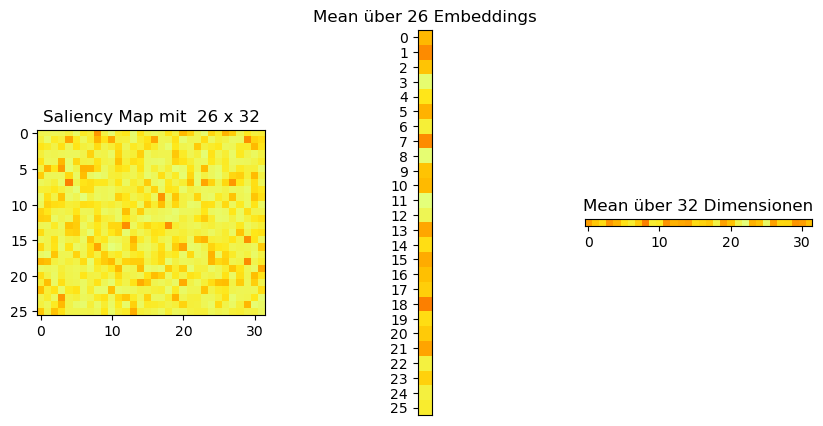

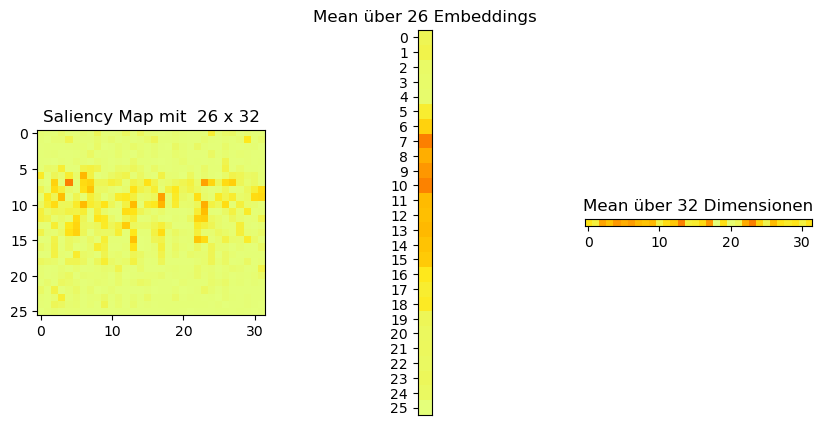

tensor(7)


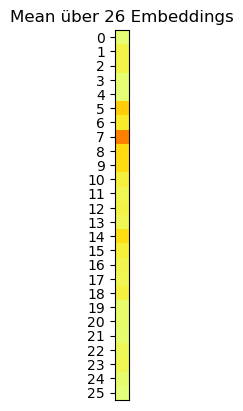

In [10]:
def plot_lime_exp_cat(lime_exp_cat, x_ticks=range(26), x_ticks_labels=range(26), combination=False, index=0):
    sm = lime_exp_cat[index].clone().detach()
    sm_summed_or_mean = sm.abs().reshape(sm.shape[0],1)

    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks(x_ticks, x_ticks_labels)
    plt.imshow(sm_summed_or_mean, cmap='Wistia')
    print(sm_summed_or_mean.argmax())
    if combination:plt.title(f'Mean über {sm.shape[0]} Embedding-Kombinationen')
    if not combination:plt.title(f'Mean über {sm.shape[0]} Embeddings')
    plt.show()

def create_mean_saliency_map(all_saliency_maps_dummy):
    mean_saliency_map = all_saliency_maps_dummy.mean(axis=0)
    return mean_saliency_map

mean_sm = create_mean_saliency_map(all_saliency_maps_dummy)
mean_lime = create_mean_saliency_map(all_lime_maps_dummy.abs().numpy())
lime_exp_mean = create_mean_saliency_map(all_lime_maps_cat_dummy.abs())

plot_saliency_map([mean_sm], x_ticks=range(26), x_ticks_labels=range(26))
plot_saliency_map([mean_lime], x_ticks=range(26), x_ticks_labels=range(26))
plot_lime_exp_cat([lime_exp_mean])

In [58]:
def window_mean(arr, window_size):
    num_windows = len(arr[0]) - window_size + 1
    result = np.zeros((len(arr), num_windows, len(arr[0][0])))
    for i in range(num_windows):
        window_mean = np.mean(arr[:,i:i+window_size], axis=1)
        result[:,i] =  window_mean
    x_ticks = np.arange(num_windows)
    x_ticks_labels = [f"{i}-{i+window_size-1}" for i in range(num_windows)]
    return result, x_ticks, x_ticks_labels

# Sliding window size
window_size = 6
result, x_ticks, x_ticks_labels = window_mean(all_saliency_maps_dummy, window_size)
result_lime, x_ticks_lime, x_ticks_labels_lime = window_mean(all_lime_maps_dummy.abs().numpy(), window_size)
# result_lime_cat, x_ticks_lime_cat, x_ticks_labels_lime_cat = window_mean(all_lime_maps_cat_dummy.abs().numpy(), window_size)

tensor(13)


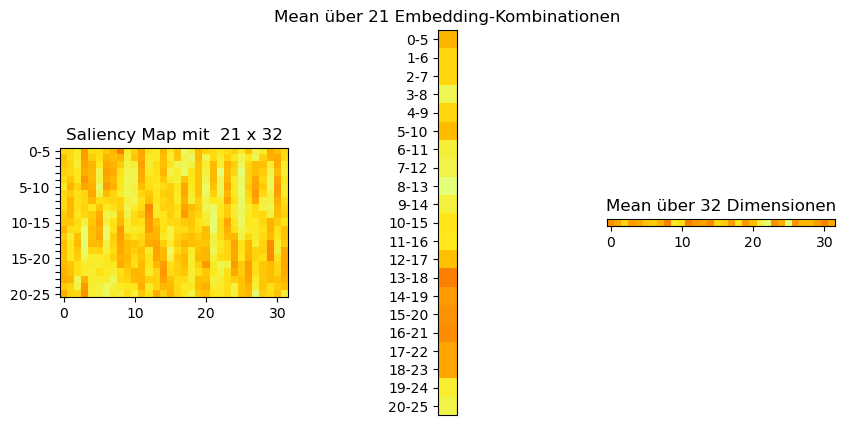

tensor(7)


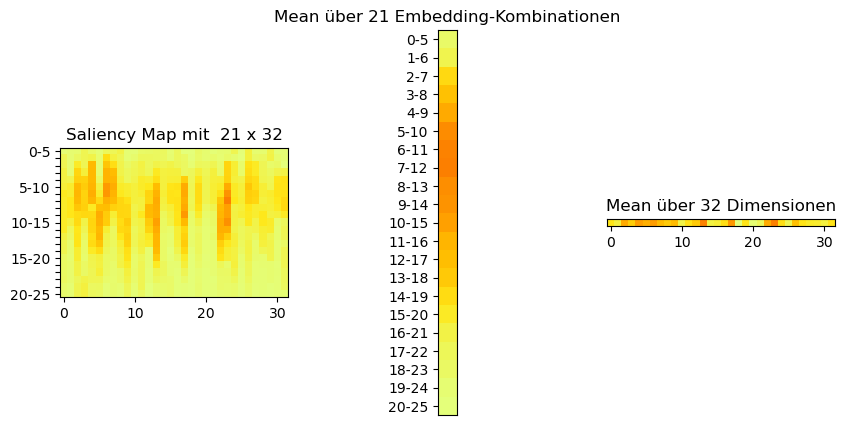

In [59]:
def plot_saliency_map_good_ticks(all_saliency_maps, x_ticks=[], x_ticks_labels=[], combination=False, model=None, index=0):
    sm = torch.tensor(all_saliency_maps[index])
    sm_summed_or_mean = sm.mean(dim=1, keepdim=True)
    sm_dim_summed_or_mean = sm.mean(dim=0, keepdim=True)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(sm, cmap='Wistia')
    plt.yticks(x_ticks, x_ticks_labels)

    plt.setp(plt.subplot(1, 3, 1).axes.get_yticklabels()[1::5], visible=False)
    plt.setp(plt.subplot(1, 3, 1).axes.get_yticklabels()[1::4], visible=False)
    plt.setp(plt.subplot(1, 3, 1).axes.get_yticklabels()[1::3], visible=False)
    plt.setp(plt.subplot(1, 3, 1).axes.get_yticklabels()[1::2], visible=False)
    plt.title(f'Saliency Map mit  {sm.shape[0]} x {sm.shape[1]}')

    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks(x_ticks, x_ticks_labels)
    plt.imshow(sm_summed_or_mean, cmap='Wistia')
    print(sm_summed_or_mean.argmax())
    if combination:plt.title(f'Mean über {sm.shape[0]} Embedding-Kombinationen')
    if not combination:plt.title(f'Mean über {sm.shape[0]} Embeddings')

    plt.subplot(1, 3, 3)
    plt.yticks([])
    plt.imshow(sm_dim_summed_or_mean, cmap='Wistia')
    plt.title(f'Mean über {sm.shape[1]} Dimensionen')
    
    plt.show()


mean_sm = create_mean_saliency_map(result)
plot_saliency_map_good_ticks([mean_sm], x_ticks, x_ticks_labels, combination=True)

mean_lime = create_mean_saliency_map(result_lime)
plot_saliency_map_good_ticks([mean_lime], x_ticks_lime, x_ticks_labels_lime, combination=True)

# mean_lime_cat = create_mean_saliency_map(result_lime_cat)

### Data Perturbations

In [43]:
import lime
import lime.lime_tabular
current_files = vqvae_v1
complete_q_embeddings = current_files["q_emb"]
current_mlp = current_files["mlp"]
current_model = current_files["model"]
current_amount_embeddings = current_model.enc_out_len
current_embedding_dim = current_files["vqvae_hparams"]["embedding_dim"]

folder_name = "saliency_maps_mlp_correct_target_class"
all_saliency_maps = np.load(f"created_files/{folder_name}/saliency_maps_v1.npy")
all_saliency_maps_embed_mean = np.load(f"created_files/{folder_name}/saliency_maps_embed_mean_v1.npy")
all_saliency_maps_dim_mean = np.load(f"created_files/{folder_name}/saliency_maps_dim_mean_v1.npy")

folder_name = "lime_maps_top_label_1_500"
all_lime_maps = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps.npy"))
all_lime_maps_embed_mean = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps_embed_mean.npy"))
all_lime_maps_dim_mean = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps_dim_mean.npy"))
all_lime_exps = np.load(f"created_files/{folder_name}/all_lime_exps.npy", allow_pickle=True).tolist()

folder_name = "lime_maps_categorical_10000"
all_lime_maps_cat = torch.tensor(np.load(f"created_files/{folder_name}/lime_maps_categorical_10000_top_label_1_2000_samples.npy"))
all_lime_exps_cat = np.load(f"created_files/{folder_name}/lime_exps_categorical_10000_top_label_1_2000_samples.npy", allow_pickle=True).tolist()


In [158]:
def predict_function(model, input_data):
    probabilities = np.zeros((len(input_data), 2))
    for i, input_data_point in enumerate(input_data):
        # print(input_data.shape)
        input_data_point = input_data_point.reshape(1,current_amount_embeddings,current_embedding_dim)
        if type(input_data_point) == np.ndarray:
            input_data_point = torch.tensor(input_data_point, dtype=torch.float32)
        input_data_point.requires_grad = True
        # print(input_data.shape)
        logits = model(input_data_point.unsqueeze(0))
        # print(logits)
        
        # for optional third dummy label
        # logits = torch.cat((logits, torch.tensor([[0]])), 1)
        probabilities[i] = torch.softmax(logits, dim=1).detach().numpy()

    return probabilities

input_data = complete_q_embeddings
input_data = input_data.numpy().reshape(input_data.shape[0],current_amount_embeddings*current_embedding_dim)
for i in range(40,60):
    print(predict_function(current_mlp, [input_data[i]]))

[[3.81032669e-06 9.99996185e-01]]
[[1.00000000e+00 2.94006952e-09]]
[[0.03046968 0.96953034]]
[[0.73913503 0.26086497]]
[[0.87008685 0.12991314]]
[[9.99287069e-01 7.13000947e-04]]
[[0.00551143 0.9944886 ]]
[[2.79440301e-05 9.99972105e-01]]
[[0.9930951  0.00690487]]
[[0.99842346 0.0015766 ]]
[[1.00000000e+00 3.86391141e-09]]
[[9.99392271e-01 6.07747468e-04]]
[[9.99994159e-01 5.80019378e-06]]
[[0.00221902 0.99778098]]
[[1.00150301e-05 9.99989986e-01]]
[[0.99789184 0.00210814]]
[[9.99921799e-01 7.82473144e-05]]
[[0.05934459 0.94065541]]
[[0.56769836 0.43230161]]
[[9.99950767e-01 4.92324180e-05]]


In [156]:
def predict_function_categorical_altered(model, input_data, codebook, alter_ind=None):
    probabilities = np.zeros((len(input_data), 2))
    for i, input_data_point in enumerate(input_data):
        print(alter_ind)
        recreated_q_embeddings = codebook[input_data_point].clone().detach()
        if alter_ind!=None: recreated_q_embeddings[alter_ind] = 0.0
        recreated_q_embeddings = recreated_q_embeddings.reshape(1,current_amount_embeddings,current_embedding_dim)
        if type(recreated_q_embeddings) == np.ndarray:
            recreated_q_embeddings = torch.tensor(recreated_q_embeddings, dtype=torch.float32)
        recreated_q_embeddings.requires_grad = True
        logits = model(recreated_q_embeddings.unsqueeze(0))
        probabilities[i] = torch.softmax(logits, dim=1).detach().numpy()
        # print the rounded values
        print(probabilities[i].round(3))
        # print(probabilities[i])
    return None

input_data = current_files["q_ind"]
indices = input_data[35]
predict_function_categorical_altered(current_mlp, [indices], current_files["codebook"])
print()

for alter_ind in range(26):
    predict_function_categorical_altered(current_mlp, [indices], current_files["codebook"], alter_ind)

None
[0.64 0.36]

0
[1. 0.]
1
[0.472 0.528]
2
[0.981 0.019]
3
[0.975 0.025]
4
[1. 0.]
5
[1. 0.]
6
[0.996 0.004]
7
[0.486 0.514]
8
[0.104 0.896]
9
[0.988 0.012]
10
[0.446 0.554]
11
[0.513 0.487]
12
[0.91 0.09]
13
[0.701 0.299]
14
[0.17 0.83]
15
[0.523 0.477]
16
[0.156 0.844]
17
[0.589 0.411]
18
[0.021 0.979]
19
[0.922 0.078]
20
[1. 0.]
21
[0.549 0.451]
22
[0.978 0.022]
23
[0.93 0.07]
24
[0.968 0.032]
25
[0.997 0.003]


In [157]:
all_lime_exps_cat[35].show_in_notebook()

# Plot relevant part for three methods

In [3]:
current_files = vqvae_v1
complete_q_embeddings = current_files["q_emb"]
current_mlp = current_files["mlp"]
current_model = current_files["model"]
current_amount_embeddings = current_model.enc_out_len
current_embedding_dim = current_files["vqvae_hparams"]["embedding_dim"]

folder_name = "saliency_maps_mlp_correct_target_class"
all_saliency_maps = np.load(f"created_files/{folder_name}/saliency_maps_v1.npy")
all_saliency_maps_embed_mean = np.load(f"created_files/{folder_name}/saliency_maps_embed_mean_v1.npy")
all_saliency_maps_dim_mean = np.load(f"created_files/{folder_name}/saliency_maps_dim_mean_v1.npy")

folder_name = "lime_maps_top_label_1_500"
all_lime_maps = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps.npy"))
all_lime_maps_embed_mean = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps_embed_mean.npy"))
all_lime_maps_dim_mean = torch.tensor(np.load(f"created_files/{folder_name}/all_lime_maps_dim_mean.npy"))
all_lime_exps = np.load(f"created_files/{folder_name}/all_lime_exps.npy", allow_pickle=True).tolist()

folder_name = "lime_maps_categorical_10000"
all_lime_maps_cat = torch.tensor(np.load(f"created_files/{folder_name}/lime_maps_categorical_10000_top_label_1_2000_samples.npy"))
all_lime_exps_cat = np.load(f"created_files/{folder_name}/lime_exps_categorical_10000_top_label_1_2000_samples.npy", allow_pickle=True).tolist()


print(all_saliency_maps.shape)
print(all_lime_maps.shape)
print(all_lime_maps_cat.shape)

(74732, 26, 32)
torch.Size([500, 26, 32])
torch.Size([10000, 26])


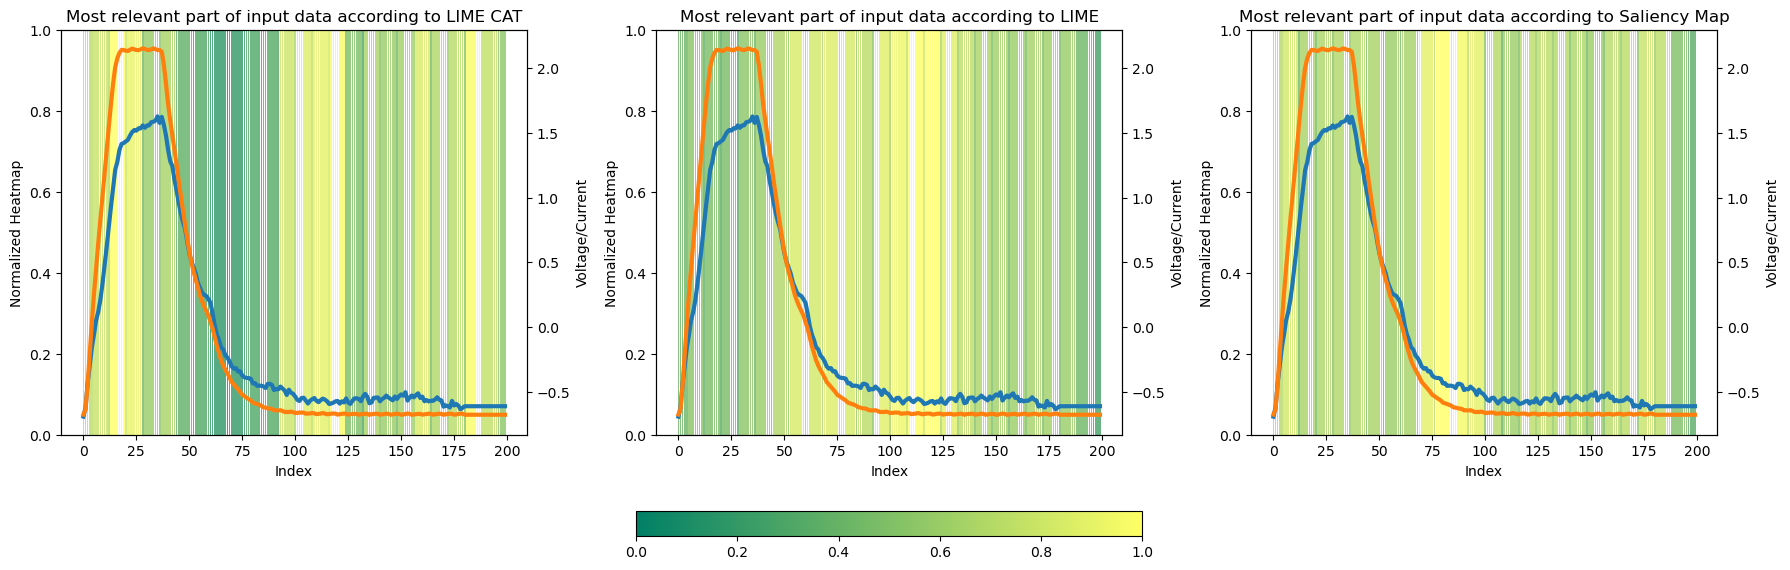

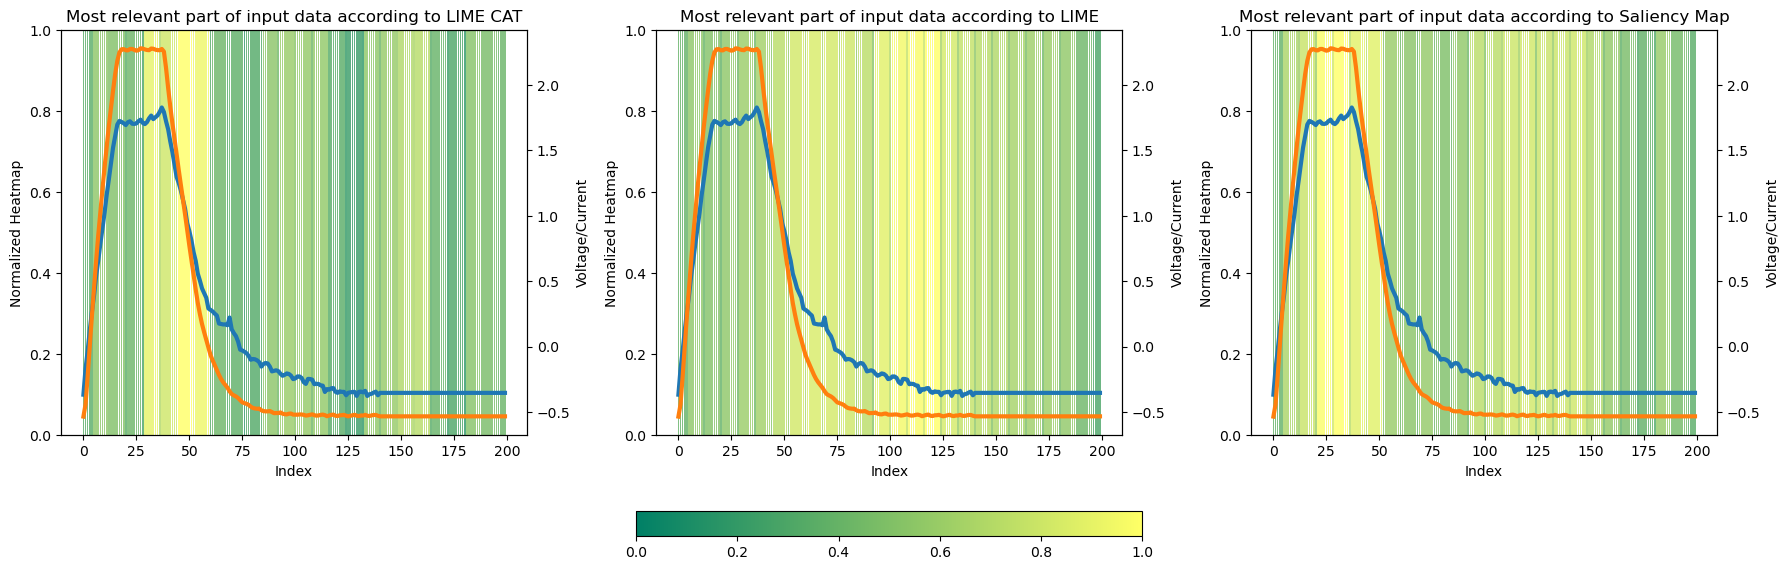

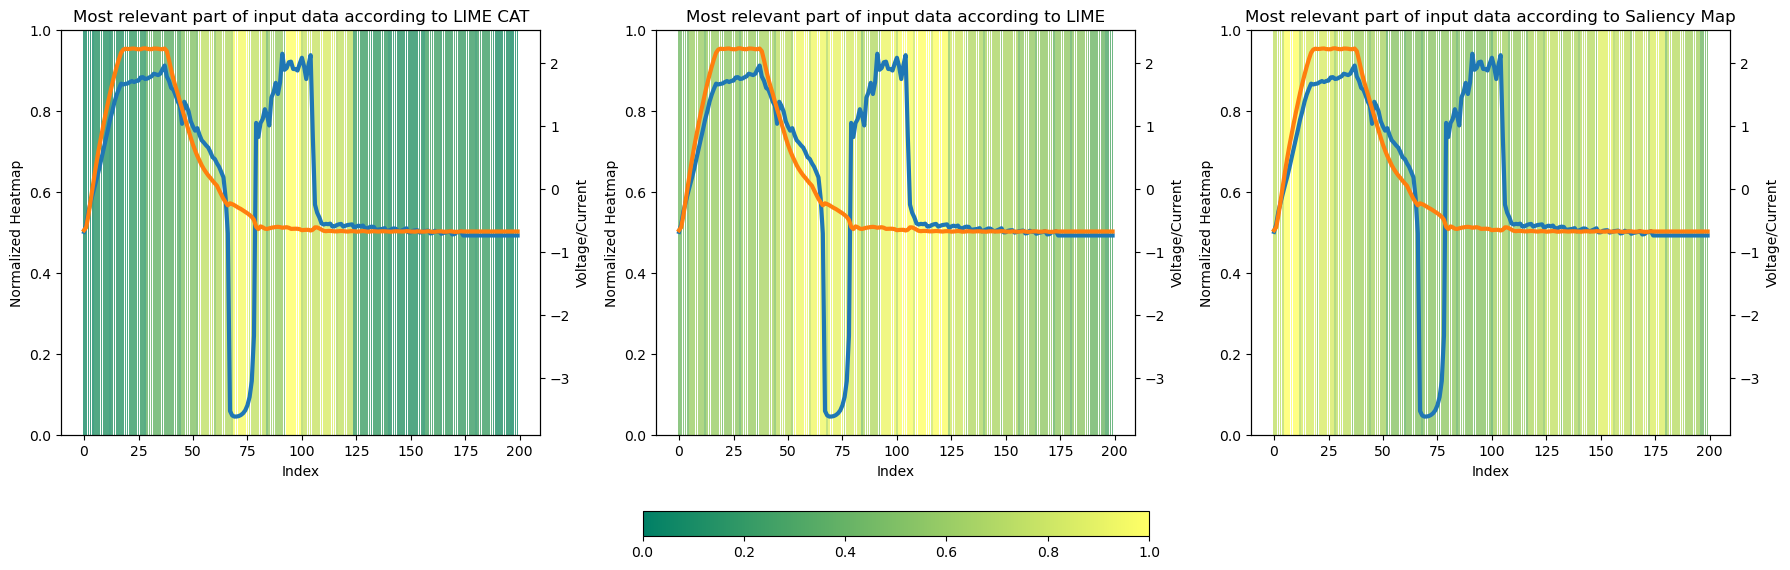

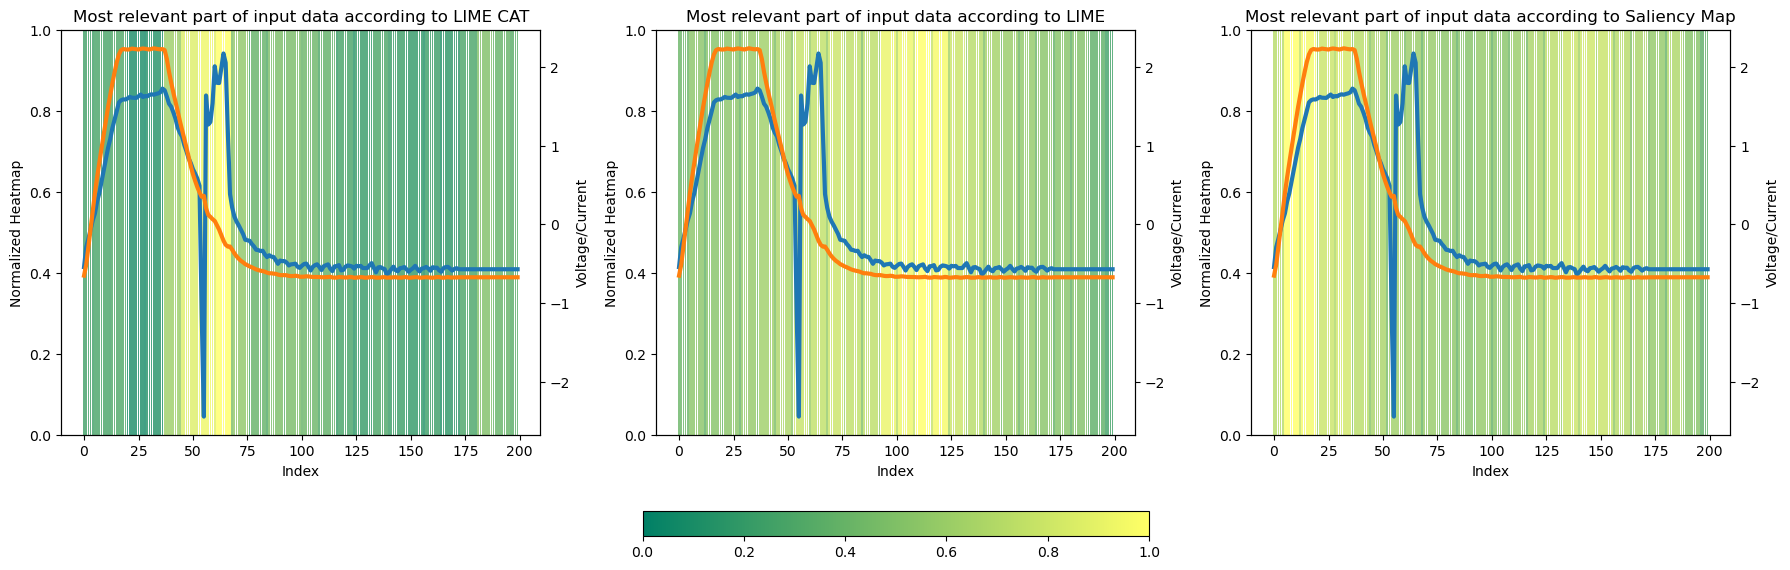

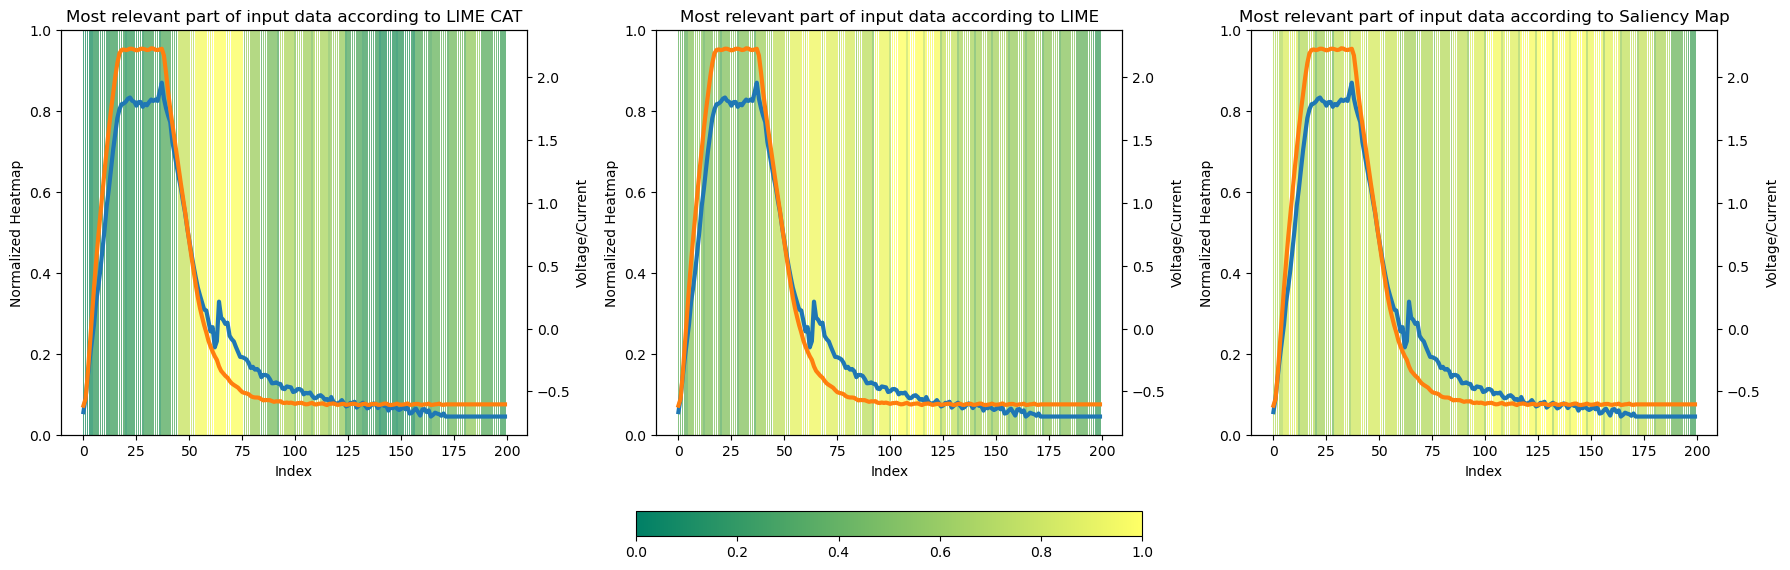

In [6]:
def plot_relevant_part_heatmap_multiple_times(lime_cat_map, lime_map, saliency_map, window_size, impact_ranges_dict, original_data, normalize_with_min=False):
    
    assert lime_cat_map.shape == torch.Size([26])
    assert lime_map.shape == saliency_map.shape == torch.Size([26, 32])

    lime_cat_mean = lime_cat_map.abs().detach().clone()
    lime_mean = lime_map.abs().mean(dim=1, keepdim=True).detach().clone()
    sm_mean = saliency_map.mean(dim=1, keepdim=True).detach().clone()
    
    heatmap_lime_cat = np.zeros((200, 1))
    heatmap_lime = np.zeros((200, 1))
    heatmap_sm = np.zeros((200, 1))

    for i in range(len(lime_cat_mean)):
        lower_border = impact_ranges_dict[i]["Start"]
        upper_border = impact_ranges_dict[i+window_size-1]["Stopp"]
        #print(lower_border, upper_border)
        heatmap_lime_cat[lower_border:upper_border+1] = heatmap_lime_cat[lower_border:upper_border+1] + lime_cat_mean[i].item()
        heatmap_lime[lower_border:upper_border+1] = heatmap_lime[lower_border:upper_border+1] + lime_mean[i].item()
        heatmap_sm[lower_border:upper_border+1] = heatmap_sm[lower_border:upper_border+1] + sm_mean[i].item()

    # # normalize heatmaps
    if normalize_with_min:
        heatmap_lime_cat_norm = (heatmap_lime_cat - heatmap_lime_cat.min()) / (heatmap_lime_cat.max()-heatmap_lime_cat.min())
        heatmap_lime_norm = (heatmap_lime - heatmap_lime.min()) / (heatmap_lime.max()-heatmap_lime.min())
        heatmap_sm_norm = (heatmap_sm - heatmap_sm.min()) / (heatmap_sm.max()-heatmap_sm.min())
    else:
        heatmap_lime_cat_norm = heatmap_lime_cat / heatmap_lime_cat.max()
        heatmap_lime_norm = heatmap_lime / heatmap_lime.max()
        heatmap_sm_norm = heatmap_sm / heatmap_sm.max()
    assert heatmap_lime_cat_norm.shape == heatmap_lime_norm.shape == heatmap_sm_norm.shape == (200, 1)

    fig, axs = plt.subplots(1,3)
    
    fig.set_size_inches(18, 6)
    colormap_heat = plt.colormaps['summer']

    bars_heatmap_lime_cat = axs[0].bar(np.arange(len(original_data)), [1] * len(original_data), color=colormap_heat(heatmap_lime_cat_norm), alpha=0.8)
    bars_heatmap_lime = axs[1].bar(np.arange(len(original_data)), [1] * len(original_data), color=colormap_heat(heatmap_lime_norm), alpha=0.8)
    bars_heatmap_sm = axs[2].bar(np.arange(len(original_data)), [1] * len(original_data), color=colormap_heat(heatmap_sm_norm), alpha=0.8)

    titles = ["LIME CAT", "LIME", "Saliency Map"]
    for i,ax in enumerate(axs):
        ax.set_ylim(0, 1)
        ax.set_xlabel('Index')
        ax.set_ylabel('Normalized Heatmap')
        axn = ax.twinx()
        axn.plot(original_data, linewidth=3)
        axn.set_ylabel('Voltage/Current')
        plt.title(f"Most relevant part of input data according to {titles[i]}")

    fig.tight_layout()
    # show colorbar of bars_heatmap below the plot
    sm = plt.cm.ScalarMappable(cmap=colormap_heat)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axs, orientation='horizontal', fraction=0.05)
    plt.show()
    return heatmap_lime_cat_norm, heatmap_lime_norm, heatmap_sm_norm

# data_point = 4
for data_point in range(5):
    lime_cat_map = all_lime_maps_cat[data_point]
    lime_map = all_lime_maps[data_point]
    sm_map = torch.tensor(all_saliency_maps[data_point])

    heatmap_lime_cat_norm, heatmap_lime_norm, heatmap_sm_norm = plot_relevant_part_heatmap_multiple_times(lime_cat_map = lime_cat_map, lime_map = lime_map, saliency_map = sm_map,
                                                        window_size=1, impact_ranges_dict=vqvae_rf_dict, original_data = torch.tensor(train_data[data_point]), normalize_with_min=False)

# print(all_lime_maps_cat[data_point].abs())